# Librerías

# Objetivo 
El objetivo del presente proyecto es la generación de una base de datos con registros hidrometeorológicos de aproximadamente 140 estaciones localizadas en el sur de la provincia de Santa Fe que se actualice diariamente de manera automática.
# Objetivos específicos 
- Diseñar la base de datos relacional
- Descargar datos históricos de las estaciones hidrometeorológicas de interés mediante web scraping y comunicación API-REST
- Insertar los datos históricos en la base de datos
- Automatizar la descarga diaria de los datos y su inserción en la base de datos
- Crear un archivo con los metadatos de cada estación meteorológica (fuente, período con información disponible, variables disponibles, datos del sensor, etc.)
- Vincular la base de datos a un Sistema de Información Geográfica (SIG) para poder ser consultados
# Metodología 
1. Desarrollo de algoritmos de web scraping con Python
2. Análisis de posibilidades técnicas para alojar la base de datos
3. Creación de la base de datos
4. Desarrollo de algoritmos de automatización de ETL (extracción, transformación y carga) de los datos
5. Vincular la base de datos con QGis
6. Elaboración de la documentación e informe final


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date,timedelta,datetime
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time


# Desarrollo

## histórico: todas estaciones criterio de retroceso 

In [21]:
estaciones_elegidas = pd.read_excel('./info_wunder.xlsx','estaciones')

In [24]:
df_cuentas_wunder=pd.read_excel('./info_wunder.xlsx','apiKeys',skiprows=2)
api_keys=df_cuentas_wunder['apiKey']
api_keys=list(api_keys)
api_keys


['06c599115fe349848599115fe309845f',
 '9018fead0aa34de798fead0aa32de757',
 'c63c8138c1b241c4bc8138c1b241c4b4',
 'ff3d7deb35a444ebbd7deb35a444ebbd',
 '2bd1dee00a454ebe91dee00a458ebe79',
 'e2aa52fada2f4902aa52fada2fa902e1',
 '3ad659ace1134a8f9659ace113aa8f81',
 '14527949de8b4a11927949de8bfa113d',
 '3f3b3235558d473dbb3235558df73d22',
 '40f85fd26c3d4861b85fd26c3dc86146',
 '33914afbb3aa4bad914afbb3aaebad27',
 '08815bdc1efa41a1815bdc1efa51a139',
 'a73d7df1ccf04596bd7df1ccf0f59636',
 '8b80656dee6f4fc580656dee6fcfc542',
 'ec77cca0d1b7488bb7cca0d1b7e88bed',
 'ae6e762c6d084cd4ae762c6d083cd4ae',
 'f4330c3d495243f8b30c3d495263f8a0',
 '52f0f4d954c144aab0f4d954c194aa00',
 'cd599783fc4e4d7d999783fc4ecd7d6c',
 'e220a3bad8254f49a0a3bad825bf49e3',
 '10f9f411db3040bab9f411db3000ba32',
 '4902c626326f4fb782c626326fffb738',
 'e20206c8df604ef28206c8df606ef232',
 '6e0b4795fa9e4ed68b4795fa9e2ed6bc',
 '610a5b77df2040408a5b77df20f040ca',
 'cf7afe50bfd84f16bafe50bfd8ff1609',
 'd84c0cfe007143178c0cfe0071b31747',
 

In [3]:
def extraer_campos_utiles(observaciones:list,dia:date,stationId:str=None)->list:
    """retorna un mensaje en torno a las observaciones agregadas
    y la fecha de la última observacoin agregada"""
    observaciones_filtrada=[]
    # Reportes completos
    if (len(observaciones)==288):
        # dia_con_obs=1 | dia_completo=1
        for observacion in observaciones:
            observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal'],1,1]
            observaciones_filtrada.append(observacion_filtrada)    
    # Reportes Incompletos
    elif ((len(observaciones)>0)):
        # dia_con_obs=1 | dia_completo=0
        for observacion in observaciones:
            observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal'],1,0]
            observaciones_filtrada.append(observacion_filtrada)    
    #No hubo reportes
    else:
        observacion_filtrada = [stationId,None,None,dia,None,None,None,None,None,0,0]
        observaciones_filtrada.append(observacion_filtrada)    
    return observaciones_filtrada     


In [95]:
def construirObservacion(obs:dict,campos:tuple)->list:
    """ Recibe una observación en formato diccionario y los campos de interés como tupla. 
    Devuelve una lista con los valores de los campos de interés """
    var_sin_unidad=["stationID","tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
    observacion=[]
    for campo in campos:
        if campo in var_sin_unidad:
            observacion.append(obs[campo])
        else:
            observacion.append(obs['metric'][campo])    
    return observacion        

In [52]:
construirObservacion({'tz':'Darío','metric':{"tempHigh":'Facundo'}},('tz','tempHigh'))

['Darío', 'Facundo']

In [104]:
def extraer_campos(observaciones:list,dia:date,stationId:str,variables:tuple)->list:
    """retorna un mensaje en torno a las observaciones agregadas
    y la fecha de la última observacoin agregada"""
    obs=[]
    #No hubo reportes
    if (len(observaciones)==0):
        observacion = [stationId,None,None,dia,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0]
        obs.append(observacion)    
    else:
        # Reportes completos
        if (len(observaciones)==288):
            # dia_con_obs=1 | dia_completo=1
            for observacion in observaciones:
                observacion = construirObservacion(observacion,variables)
                observacion+=[1,1]
                obs.append(observacion)    
        # Reportes Incompletos
        else:
            # dia_con_obs=1 | dia_completo=0
            for observacion in observaciones:
                observacion = construirObservacion(observacion,variables)
                observacion+=[1,0]
                obs.append(observacion)  
    return obs 

In [27]:
def cambiar_api_key(conjunto_api_key:list[str],api_key_actual:str)->str:
    indice_api_key_actual=conjunto_api_key.index(api_key_actual)
    if indice_api_key_actual==len(conjunto_api_key)-1:
        return ''
    else:
        siguiente_api_key=conjunto_api_key[indice_api_key_actual+1]
        return siguiente_api_key


In [80]:
cambiar_api_key(api_keys,'0f80b73561fe451b80b73561fe651b08')

'9018fead0aa34de798fead0aa32de757'

In [28]:
def imprimir_mensaje(situacion:str,vieja_api_key:str=None,url:str=None,llamadas_totales:int=None,
    identificador_estacion:str=None,dia:date=None,status_code:int=None,n_error_con:int=None,problema=None)->None:
    #Se agotó el cupo de llamadas por api key
    if (situacion=='llamada 1400'):
        print(f'cambio de api key por llamada 1400. Vieja api key\n{vieja_api_key}')
    #La api key no tiene autorización
    elif (situacion=='api key desautorizada'):
        print(f'cambio de api key por problmeas de autorización.\nRespuesta:{status_code}.\nVieja api key\n{vieja_api_key}')
    #El servidor no responde
    elif (situacion=='el servidor no contesta'):
        print(f'Problemas con el servidor web.\nRespuesta:{status_code}.\nSe pausa durante una hora la ejecución.\nHora de pausa:{datetime.now()}')
    elif (situacion=='respesta del servidor desconocida'):
        print(f'Se obtuvo una respuesta desconocida.\nRespuesta:{status_code}.\nLlamado:{url}')
    elif (situacion=='error de conexión'):
        print(f'Hubo un problema con la conexión al servidor.\nError número:{n_error_con}.\nError:{problema}')  
    #Se agotaron todas las api keys
    elif(situacion=='sin api keys'):
        print(f'se consumieron todas las api keys disponibles.\nÚltimo llamado:{url}.\nTotal de llamadas:{llamadas_totales}')
    #La estación registró 30 días consecutivos sin reportes
    elif(situacion=='cambio de estacion'):
        print(f'se cargaron todas las observacines de {identificador_estacion}.\nel último día con observaciones fue {dia.year}:{dia.month}:{dia.day}')
    elif(situacion=='ejecucion exitosa'):
        print(f'El bloque de código se ejecutó exitosamente.\nTotal de llamadas:{llamadas_totales}')


In [6]:

imprimir_mensaje(situacion='llamada 1400',vieja_api_key='ad2')
imprimir_mensaje(situacion='cambio de estacion',identificador_estacion='ros',dia=datetime.now())
imprimir_mensaje(situacion='api key desautorizada',status_code=401,vieja_api_key='as')
imprimir_mensaje(situacion='sin api keys',url='https',llamadas_totales=102)
imprimir_mensaje(situacion='el servidor no contesta',status_code=500)
imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=403,url='https')   
imprimir_mensaje(situacion='error de conexión',n_error_con=3,problema='error SSL')    
imprimir_mensaje(situacion='ejecucion exitosa',llamadas_totales=689)    

cambio de api key por llamada 1400. Vieja api key
ad2
se cargaron todas las observacines de ros.
el último día con observaciones fue 2024:8:30
cambio de api key por problmeas de autorización.
Respuesta:401.
Vieja api key
as
se consumieron todas las api keys disponibles.
Último llamado:https.
Total de llamadas:102
Problemas con el servidor web.
Respuesta:500.
Se pausa durante una hora la ejecución.
Hora de pausa:2024-08-30 08:46:54.514978
Se obtuvo una respuesta desconocida.
Respuesta:403.
Llamado:https
Hubo un problema con la conexión al servidor.
Error número:3.
Error:error SSL
El bloque de código se ejecutó exitosamente.
Total de llamadas:689


In [103]:
def escribirObservaciones(stationId:str,observaciones:list,campos:tuple)->None:
    with open(f'C:/Users/Usuario/Documents/observaciones/observaciones_completas_{stationId}.csv','w',newline='') as csv_file:
            writer = csv.writer(csv_file)
            header = [campo for campo in campos]
            header+=["dia_con_obs","dia_completo"]
            writer.writerow(header) 
            writer.writerows(observaciones)

In [37]:
observaciones=[['ros1',2,3,4,5,6,7,8,9,10,11],['ros1',2,3,4,5,6,7,8,9,10,11]]
escribirObservaciones('ros1',observaciones)

In [29]:
def extraccionDatosObservaciones(id_estaciones:pd.Series,claves_api:list[int])->None:
    #Seteo de variables
    numero_llamada_global=0
    numero_llamada_api_key=0
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    for id_estacion in id_estaciones:
        #Se setean las variables de cada iteración
        dias_seguidos_sin_observaciones=0
        fecha=date(2024,8,19)
        total_observaciones=[]  
        while True:
            if (numero_llamada_api_key==1400):
                    imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                    api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                    #Si se agotaron las api keys se rompe el bucle white
                    if (api_key==''):
                        break  
                    numero_llamada_api_key=0
            fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
            recurso=f'https://api.weather.com/v2/pws/history/all?stationId={id_estacion}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
            try:
                respuesta = requests.get(recurso)
                codigo_respusta=respuesta.status_code
                numero_llamada_api_key+=1
                numero_llamada_global+=1
                # Status Code 200: OK. The request has succeeded.
                # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
                if (codigo_respusta==200 or codigo_respusta==204):
                    observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else []
                    if (len(observaciones_un_dia)==0):
                        dias_seguidos_sin_observaciones+=1
                    else:
                        dias_seguidos_sin_observaciones=0        
                    # Se setea en 31 el corte para que se admitan hasta 30 días consecutivos sin reportes 
                    if (dias_seguidos_sin_observaciones==31):
                        #Se retrocede un día para que imprima la última fecha cargada
                        fecha-= timedelta(days=1)
                        imprimir_mensaje(situacion='cambio de estacion',identificador_estacion=id_estacion,dia=fecha)
                        break    
                    total_observaciones+=extraer_campos_utiles(observaciones_un_dia,fecha,id_estacion)
                    fecha-= timedelta(days=1)
                elif (codigo_respusta==401):
                    # Status Code 401: Unauthorized. The request requires authentication.
                    imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                    api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                    #Si se agotaron las api keys se rompe el bucle white
                    if (api_key==''):
                        break  
                    numero_llamada_api_key=0      
                elif (codigo_respusta==500):
                    imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                    una_hora=60*60
                    #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                    time.sleep(una_hora)
                else:
                    imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
            except requests.exceptions.RequestException as error:
                numero_error_conexion+=1
                imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error)    
        #Escribe todas las observaciones recolectadas de la estación antes de saltar a la siguiente
        escribirObservaciones(stationId=id_estacion,observaciones=total_observaciones)
        #Si se agotaron las api keys se rompe el bucle for
        if (api_key==''):    
            imprimir_mensaje(situacion='sin api keys',url=recurso,llamadas_totales=numero_llamada_global)
            break
    imprimir_mensaje(situacion='ejecucion exitosa',llamadas_totales=numero_llamada_global)      

In [23]:
id_estaciones_para_carga= estaciones_elegidas.loc[125:,"id"]
id_estaciones_para_carga

125     ISANNICO24
126       ISANTA43
127      ISANTA203
128      ISANTA538
129     ISANTA1211
130     ISANTAFE23
131     ISANTAFE60
132    ISANTAFE105
133        ISARGE5
134        ITORTU3
135        IUNIND8
136      IUNINDEP8
137        IVENAD3
138      IVILLA133
139     IVILLA1083
140         IPREZ1
141       ICASER41
142       ICASER32
Name: id, dtype: object

In [28]:
extraccionDatosObservaciones(id_estaciones_para_carga,api_keys)

<class 'pandas.core.series.Series'>
<class 'list'>


In [124]:
def extraccionDatosObservacionesUnaEstacion(estacion_id,claves_api:list[int])->None:
    #Seteo de variables
    numero_llamada_global=0
    numero_llamada_api_key=0
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    total_observaciones=[]  
    fecha=date(2012,6,1)
    fecha_limite = date(2024,8,29)
    var_sin_unidad=['stationID',"tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
    var_con_unidad=["tempHigh","tempLow","tempAvg","windspeedHigh","windspeedLow","windspeedAvg","windgustHigh","windgustLow","windgustAvg","dewptHigh","dewptLow","dewptAvg","windchillHigh","windchillLow","windchillAvg","heatindexHigh","heatindexLow","heatindexAvg","pressureMax","pressureMin","pressureTrend","precipRate","precipTotal"]
    var_todas=tuple(var_sin_unidad+var_con_unidad)
    while fecha<=fecha_limite:
        if (numero_llamada_api_key==1400):
                imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                #Si se agotaron las api keys se rompe el bucle white
                if (api_key==''):
                    break  
                numero_llamada_api_key=0
        fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
        recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
        try:
            respuesta = requests.get(recurso)
            codigo_respusta=respuesta.status_code
            numero_llamada_api_key+=1
            numero_llamada_global+=1
            # Status Code 200: OK. The request has succeeded.
            # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
            if (codigo_respusta==200 or codigo_respusta==204):
                observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else [] 
                total_observaciones+=extraer_campos(observaciones_un_dia,fecha,estacion_id,var_todas)
                fecha+= timedelta(days=1)
            elif (codigo_respusta==401):
                # Status Code 401: Unauthorized. The request requires authentication.
                imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                #Si se agotaron las api keys se rompe el bucle white
                if (api_key==''):
                    break  
                numero_llamada_api_key=0      
            elif (codigo_respusta==500):
                imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                una_hora=60*60
                #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                time.sleep(una_hora)
            else:
                imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
        except requests.exceptions.RequestException as error:
            numero_error_conexion+=1
            imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error)    
    #Escribe todas las observaciones recolectadas de la estación antes de saltar a la siguiente
    escribirObservaciones(estacion_id,total_observaciones,var_todas)
    #Si se agotaron las api keys se rompe el bucle for
    if (api_key==''):    
        imprimir_mensaje(situacion='sin api keys',url=recurso,llamadas_totales=numero_llamada_global)
        return
    imprimir_mensaje(situacion='ejecucion exitosa',llamadas_totales=numero_llamada_global)  

In [125]:
extraccionDatosObservacionesUnaEstacion(estacion_id='ISANTAFE23',claves_api=api_keys)

cambio de api key por problmeas de autorización.
Respuesta:401.
Vieja api key
06c599115fe349848599115fe309845f
cambio de api key por problmeas de autorización.
Respuesta:401.
Vieja api key
9018fead0aa34de798fead0aa32de757
cambio de api key por problmeas de autorización.
Respuesta:401.
Vieja api key
c63c8138c1b241c4bc8138c1b241c4b4
Hubo un problema con la conexión al servidor.
Error número:1.
Error:HTTPSConnectionPool(host='api.weather.com', port=443): Max retries exceeded with url: /v2/pws/history/all?stationId=ISANTAFE23&format=json&units=m&apiKey=ff3d7deb35a444ebbd7deb35a444ebbd&numericPrecision=decimal&date=20180925 (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1006)')))
cambio de api key por llamada 1400. Vieja api key
ff3d7deb35a444ebbd7deb35a444ebbd
cambio de api key por llamada 1400. Vieja api key
2bd1dee00a454ebe91dee00a458ebe79
El bloque de código se ejecutó exitosamente.
Total de llamadas:4476


In [10]:
def lluviaAcumuladaDiaria(estacionId:str,año:int,mes:int,dia:int)->None:    
    df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/observaciones_{estacionId}.csv')
    df_estacion['obsTimeLocal'] = pd.to_datetime(df_estacion['obsTimeLocal'],format='mixed')
    df_dia_buscado = df_estacion[(df_estacion['obsTimeLocal'].dt.year==año)&(df_estacion['obsTimeLocal'].dt.month==mes)&(df_estacion['obsTimeLocal'].dt.day==dia)].reset_index()
    precipitaciones = df_dia_buscado['precipTotal_mm']
    ultima_precipitacion = float(precipitaciones.loc[len(precipitaciones)-1])
    return f'En la fecha {año}-{mes}-{dia} la estación {estacionId} registró una precipitación acumulada de {ultima_precipitacion} mm'
    

In [11]:
lluviaAcumuladaDiaria('iadeli1',2024,6,22)

'En la fecha 2024-6-22 la estación iadeli1 registró una precipitación acumulada de 2.31 mm'

In [44]:
def contarTotalObservaciones(estaciones_id:pd.Series)->int:
    "Itera sobre cada csv y devuelve la cantidad total de observaciones"
    total_obs=0
    for i,estacion_id in enumerate(list(estaciones_id)):
        df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/observaciones_{estacion_id}.csv')
        total_obs += len(df_estacion)
        print(i)
    return total_obs        

In [45]:
obs_totales = contarTotalObservaciones(estaciones_elegidas['id'])
'{:,}'.format(obs_totales)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142


'31,977,051'

In [2]:
df_estacion = pd.read_csv('C:/Users/Usuario/Documents/observaciones/observaciones_completas_ISANTAFE23.csv')
df_estacion['obsTimeLocal']=pd.to_datetime(df_estacion['obsTimeLocal'],format='mixed')
df_estacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113339 entries, 0 to 1113338
Data columns (total 39 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   stationID           1113339 non-null  object        
 1   tz                  1113180 non-null  object        
 2   obsTimeUtc          1113180 non-null  object        
 3   obsTimeLocal        1113339 non-null  datetime64[ns]
 4   epoch               1113180 non-null  float64       
 5   lat                 1113180 non-null  float64       
 6   lon                 1113180 non-null  float64       
 7   solarRadiationHigh  65571 non-null    float64       
 8   uvHigh              65571 non-null    float64       
 9   winddirAvg          1112361 non-null  float64       
 10  humidityHigh        1113100 non-null  float64       
 11  humidityLow         1113100 non-null  float64       
 12  humidityAvg         1113100 non-null  float64       
 13  qcStatus    

In [8]:
df_estacion.columns

Index(['stationID', 'tz', 'obsTimeUtc', 'obsTimeLocal', 'epoch', 'lat', 'lon',
       'solarRadiationHigh', 'uvHigh', 'winddirAvg', 'humidityHigh',
       'humidityLow', 'humidityAvg', 'qcStatus', 'tempHigh', 'tempLow',
       'tempAvg', 'windspeedHigh', 'windspeedLow', 'windspeedAvg',
       'windgustHigh', 'windgustLow', 'windgustAvg', 'dewptHigh', 'dewptLow',
       'dewptAvg', 'windchillHigh', 'windchillLow', 'windchillAvg',
       'heatindexHigh', 'heatindexLow', 'heatindexAvg', 'pressureMax',
       'pressureMin', 'pressureTrend', 'precipRate', 'precipTotal',
       'dia_con_obs', 'dia_completo'],
      dtype='object')

In [16]:
df_estacion.head()

stationID                    tz            obsTimeUtc        obsTimeLocal  \
0  ISANTAFE23  America/Buenos_Aires  2012-06-01T03:03:00Z 2012-06-01 00:03:00   
1  ISANTAFE23  America/Buenos_Aires  2012-06-01T03:08:00Z 2012-06-01 00:08:00   
2  ISANTAFE23  America/Buenos_Aires  2012-06-01T03:13:00Z 2012-06-01 00:13:00   
3  ISANTAFE23  America/Buenos_Aires  2012-06-01T03:18:00Z 2012-06-01 00:18:00   
4  ISANTAFE23  America/Buenos_Aires  2012-06-01T03:23:00Z 2012-06-01 00:23:00   

          epoch        lat        lon  solarRadiationHigh  uvHigh  winddirAvg  \
0  1.338520e+12 -34.095276 -61.628315                 NaN     NaN         0.0   
1  1.338520e+12 -34.095276 -61.628315                 NaN     NaN        90.0   
2  1.338520e+12 -34.095276 -61.628315                 NaN     NaN        90.0   
3  1.338521e+12 -34.095276 -61.628315                 NaN     NaN        90.0   
4  1.338521e+12 -34.095276 -61.628315                 NaN     NaN       180.0   

   ...  heatindexHigh  heatindexLow  heatindexAvg  pressureMax  pressureMin  \
0  ...            NaN           NaN           NaN      1013.21      1013.21   
1  ...            NaN           NaN           NaN      1013.21      1013.21   
2  ...            NaN           NaN           NaN      1013.21      1013.21   
3  ...            NaN           NaN           NaN      1013.21      1013.21   
4  ...            NaN           NaN           NaN      1013.55      1013.55   

   pressureTrend  precipRate  precipTotal  dia_con_obs  dia_completo  
0            0.0         0.0          0.0            1             1  
1            0.0         0.0          0.0            1             1  
2            0.0         0.0          0.0            1             1  
3            0.0         0.0          0.0            1             1  
4            0.0         0.0          0.0            1             1  

[5 rows x 39 columns]

In [162]:
df_estacion[['humidityLow','humidityAvg','humidityHigh']]

humidityLow  humidityAvg  humidityHigh
0               93.0         93.0          93.0
1               93.0         93.0          93.0
2               93.0         93.0          93.0
3               93.0         93.0          93.0
4               93.0         93.0          93.0
...              ...          ...           ...
1113334         86.0         86.0          86.0
1113335         86.0         86.0          86.0
1113336         87.0         87.0          87.0
1113337         88.0         88.0          88.0
1113338         87.0         87.0          87.0

[1113339 rows x 3 columns]

In [163]:
df_estacion[['tempLow','tempAvg','tempHigh']]

tempLow  tempAvg  tempHigh
0           10.9     10.9      10.9
1           10.9     10.9      10.9
2           10.9     10.9      10.9
3           10.8     10.8      10.8
4           10.7     10.7      10.7
...          ...      ...       ...
1113334      8.3      8.3       8.3
1113335      8.1      8.1       8.1
1113336      8.0      8.0       8.0
1113337      7.9      7.9       7.9
1113338      8.2      8.2       8.2

[1113339 rows x 3 columns]

In [167]:
df_estacion[['dewptLow','dewptAvg','dewptHigh']]

dewptLow  dewptAvg  dewptHigh
0             9.8       9.8        9.8
1             9.8       9.8        9.8
2             9.8       9.8        9.8
3             9.7       9.7        9.7
4             9.6       9.6        9.6
...           ...       ...        ...
1113334       6.1       6.1        6.1
1113335       5.9       5.9        5.9
1113336       6.0       6.0        6.0
1113337       6.0       6.0        6.0
1113338       6.2       6.2        6.2

[1113339 rows x 3 columns]

In [172]:
df_estacion[['heatindexLow','heatindexAvg','heatindexHigh']]

heatindexLow  heatindexAvg  heatindexHigh
0                 NaN           NaN            NaN
1                 NaN           NaN            NaN
2                 NaN           NaN            NaN
3                 NaN           NaN            NaN
4                 NaN           NaN            NaN
...               ...           ...            ...
1113334           8.3           8.3            8.3
1113335           8.1           8.1            8.1
1113336           8.0           8.0            8.0
1113337           7.9           7.9            7.9
1113338           8.2           8.2            8.2

[1113339 rows x 3 columns]

In [10]:
df_estacion[['pressureMin','pressureTrend','pressureMax']]

pressureMin  pressureTrend  pressureMax
0            1013.21            0.0      1013.21
1            1013.21            0.0      1013.21
2            1013.21            0.0      1013.21
3            1013.21            0.0      1013.21
4            1013.55            0.0      1013.55
...              ...            ...          ...
1113334      1026.75            NaN      1026.75
1113335      1026.41            NaN      1026.41
1113336      1026.41            NaN      1026.41
1113337      1026.41            NaN      1026.41
1113338      1026.41            NaN      1026.41

[1113339 rows x 3 columns]

In [4]:
def min_max(df,variable):
    min=df[variable].min()
    max=df[variable].max()
    return min,max

In [141]:
variable='epoch'
min,max=min_max(df_estacion,'epoch')
print(variable,min,max)

epoch 1530414293.0 1564109756000.0


In [144]:
variable='solarRadiationHigh'
min,max=min_max(df_estacion,'solarRadiationHigh')
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

solarRadiationHigh 0.0 2206.0


array([  73.,   22., 1983.,  558.,  632.,  706.,  742.,  779.,  780.,
        743.,  705.,  411.,  155.,  192.,  412.,  668.,  888.,  777.,
        484.,  374.,  154.,  118.,   81.,   82.,   45.,   46.,  119.,
          9.,   10.,  266.,  522.,  778.,  521.,  301.,  228.,  229.,
        486., 1071., 1181.,  447.,  227.,  376.,  741.,  594.,    8.,
        191.,  448.,   80.,  117.,  153.,  190.,  373.,  446.,  556.,
        263.,  226.,  336.,  300.,  264.,  302.,  338.,  339.,  265.,
        375.,  704.,  667.,  156.,   83.,  449.,  485.,  193.,  669.,
        961., 1145., 1108.,  595.,   84.,  157.,  340.,  450.,  559.,
        120.,  303., 2130., 1876.,   44.,  740.,  850.,  887.,  922.,
        739.,  702.,  665.,  519.,  299.,  337.,  483.,  557.,  593.,
        886.,   40.,  114.,  150.,  224.,  260.,  297.,  371.,  407.,
        334.,  298.,  261.,  225.,  188.,  115.,   79.,   42.,    7.,
        410.,  631.,   43.,    0.,  230.,  267.,  413.,  520.,  630.,
        666.,  703.,

In [145]:
variable='uvHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

uvHigh 0.0 15.0


array([ 2., 11.,  0.,  1., 15.,  3.])

In [ ]:
variable='uvHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

In [146]:
variable='winddirAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

winddirAvg 0.0 359.0


array([  0.,  90., 180.,  45., 158., 338., 315., 135.,  22., 292., 270.,
       225., 248., 202., 112., 229., 249., 256., 267., 259., 245., 258.,
       232., 236., 227., 240., 291., 260., 247., 251., 272., 285., 296.,
       301., 207., 206., 243., 241., 238., 265., 244., 239., 254., 257.,
       234., 190., 165., 169., 192., 220., 255., 281.,  14.,   1.,  12.,
        10., 113., 203., 293.,  23.,  17.,  33.,  68., 341., 326.,   4.,
         6.,   2., 359., 324., 348., 349.,  46.,   7.,  11.,  38.,  30.,
        36., 329., 352.,  19., 344., 354.,  27., 353., 347., 340.,  24.,
       355.,  26.,  28., 356., 313., 271., 280., 288., 264., 269., 268.,
       237., 295., 125.,  87., 214., 118.,  34.,  54., 336., 331.,  20.,
       318., 152.,  79., 333., 110.,  75., 167., 343.,  32., 337., 325.,
        13.,  71., 201.,  21., 193., 147., 155.,  57., 358., 327.,  29.,
       294.,  98., 217., 213., 191., 266., 339.,  67., 274., 111., 101.,
       146.,  65.,  35., 143., 124., 116., 303., 19

In [149]:
variable='humidityHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

humidityHigh 0.0 99.0


array([93., 94., 95., 96., 97., 98., 99., 92., 91., 89., 88., 87., 86.,
       85., 84., 81., 80., 76., 75., 74., 73., 72., 70., 69., 67., 66.,
       63., 62., 61., 60., 58., 57., 56., 55., 54., 53., 52., 50., 51.,
       49., 48., 47., 45., 44., 43., 42., 41., 38., 37., 36., 35., 40.,
       39., 46., 65., 64., 59., 68., 71., 77., 78., 79., 82., 83., 34.,
       33., 32., 31., 90., 30., 29., 28., 27., 26., 25., 24., 23., 22.,
       21., 20., 19., 18., 17.,  0., 14.,  1.,  7., 16., 12., 15., 10.,
       11., 13.])

In [153]:
variable='qcStatus'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

qcStatus -1.0 1.0


array([-1.,  1.,  0.])

In [156]:
variable='tempAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

tempAvg -22.4 41.3


array([ 10.9,  10.8,  10.7,  10.4,  10.2,  10.3,  10.5,  10.6,  10.1,
        10. ,   9.9,   9.7,   9.5,   9.4,   9.3,   9.2,   9.1,   9. ,
         8.9,   8.8,   9.6,   8.7,   8.6,  11.1,  11.3,  11.5,  11.7,
        11.8,  12.1,  12.4,  12.7,  13. ,  13.4,  13.8,  14.2,  14.7,
        15. ,  15.2,  15.5,  15.7,  16. ,  16.2,  16.7,  16.9,  16.8,
        17.3,  17.6,  17.8,  18. ,  18.3,  18.5,  18.6,  18.8,  19. ,
        19.1,  19.2,  19.5,  19.6,  19.8,  19.9,  20.1,  20. ,  20.3,
        20.4,  20.6,  20.7,  21.1,  21. ,  21.2,  21.4,  21.5,  21.7,
        21.8,  21.9,  22. ,  22.3,  22.1,  22.2,  22.5,  22.8,  22.9,
        23. ,  22.7,  22.4,  21.6,  21.3,  20.9,  18.9,  18.4,  17.4,
        17.1,  16.6,  16.5,  16.4,  16.3,  16.1,  15.9,  15.8,  15.6,
        15.4,  14.8,  14.6,  14.5,  14.4,  14.3,  14.1,  14. ,  13.6,
        13.5,  13.7,  13.9,  13.3,  13.2,  12.8,  12.9,  13.1,  12.6,
        12.3,  12. ,  12.2,  11.9,  11. ,   9.8,  11.6,  12.5,  14.9,
        17.5,  19.3,

In [164]:
variable='windspeedHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windspeedHigh 0.0 490.4


array([  1.8,   0. ,   5.6,   3.7,   5. ,   7.4,   9.3,   6.1,  11.1,
        13. ,  14.8,  18.5,  16.7,  20.4,  22.2,  25.9,  24.1,  29.6,
         9.7,  13.4,  22. ,  27.8,  33.3,  28.2,  25.6,   4.8,  11.3,
        12.9,  14.5,   1.6,  16.1,   8. ,   8.7,  12.2,   7.2,  15.8,
         3.5,   2.6,   1.1,  18.3,  21.9,  23.3,  24.5,  20.8,  19.5,
        26.9,  30.6,  31.5,  25.4,  17.2,  34.3,   3.2,  20.9,  29.5,
        28. ,  34.1,  36.7,  33. ,  39.1,  40.2,  41.7,  35.6,  42.8,
        37.7,  45.2,  43.8,  48.9,  46.3,  47.8,  52.5,  60. ,  58.6,
        62.1,  63.6,  49.9,  51.3,  56. ,  55. ,  57.5,  68.2,  64.7,
        66.1,  53.9, 247.8, 111. ,  61. , 140. , 490.4,  46. ,  28.8,
        53.6,  19. ,  31.7,  27. ,  33.2,  40.4,  39.3,  37.8,  45.4,
        43.9,  46.5,  48. ,  51.5,  57.6,  52.6,  58.7,  50.1,  64.9,
        67.3,  60.2,  54.1,  61.2,  74.5,  62.3,  68.4,  66.3,  63.7,
        73.4,  69.8,  56.2,  71. ,  76. ,   5.8,  80.6,  85.6, 166.2,
       100.4, 296.6,

In [158]:
variable='windgustLow'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windgustLow 0.0 501.1


array([  0. ,   1.8,   5.6,   3.7,   5. ,   6.1,   7.4,   9.3,  11.1,
        13. ,  14.8,  18.5,  16.7,  20.4,  22.2,  25.9,  24.1,  29.6,
         9.7,  13.4,  22. ,  27.8,  33.3,  28.2,  25.6,  12.9,  11.3,
         4.8,   8. ,  17.7,  15.8,  12.2,  17.2,  18.3,  19.5,  20.8,
         8.7,   7.2,   3.5,   2.6,   1.1,  23.3,  25.4,  34.1,  28. ,
        29.5,  31.5,  33. ,  30.6,  24.5,  36.7,  40.2,  41.7,  39.1,
        21.9,  35.6,  26.9,  34.3,  20.9,   6.4,   3.2,   1.6,  19.3,
        16.1,  14.5,  37.7,  43.8,  45.2,  42.8,  46.3,  47.8,  49.9,
        48.9,  52.5,  55. ,  51.3,  56. ,  53.9,  58.6,  66.1,  74.4,
        67.1,  57.5,  72.3,  62.1,  60. ,  61. ,  63.6,  64.7,  70.8,
        69.7,  68.2,  80.5,  73.2,  79.3,  85.5, 249.6, 111. ,  78.4,
        81.9, 142.6,  76.9, 490.4, 131.2, 330.4, 501.1,  28.8, 146.9,
        53.6,  91.6, 226.6, 343.1, 311.1,  33.2,  31.7,  27. ,  40.4,
        37.8,  39.3,  54.1,  43.9,  45.4,  46.5,  48. ,  52.6,  50.1,
        51.5,  57.6,

In [169]:
variable='dewptHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

dewptHigh -28.0 37.7


array([  9.8,   9.7,   9.6,   9.3,   9.1,   9.4,   9.9,   9.5,   9.2,
         8.9,   9. ,   8.8,   8.7,   8.6,   8.4,   8.3,   8.5,  10.2,
        10.3,  10.4,  10.7,  10.9,  11.2,  11. ,  11.3,  10.8,  10.6,
        11.1,  10.5,   8.1,   7.3,   7.1,   7.2,   6.9,   6.4,   7.4,
         6.6,   6.7,   7. ,   7.5,   7.9,   7.6,   8.2,   8. ,   7.8,
        10. ,  10.1,   6.8,   6.5,   7.7,   5.8,   5.4,   5.2,   5.9,
         6. ,   4.9,   5.3,   5.6,   4.8,   4.3,   4.4,   5.1,   4.6,
         3.9,   3.5,   3.6,   3.7,   4. ,   4.1,   4.2,   3.8,   4.7,
         4.5,   5. ,   5.7,   3.4,   3.2,   3.3,   3.1,   3. ,   2.7,
         2.9,   2.8,   2.6,   1.6,   1.8,   1.9,   2.3,   6.1,   6.2,
         6.3,   2.4,   2.2,   2.1,   1.7,   2. ,   1.5,   1.4,   2.5,
         1.1,   0.9,   0.7,   0.6,   0.8,   1. ,   0.5,   0.4,   0.3,
         1.2,   0.2,   0.1,  -0.3,  -0.6,  -0.7,  -0.8,  -1.1,  -1.2,
        -1.3,  -1.4,  -1.6,  -1.9,  -2. ,  -2.1,  -1.8,  -1.7,  -2.4,
        -2.5,  -2.2,

In [170]:
variable='windchillHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windchillHigh -31.0 41.3


array([ 26.3,  25.8,  25.5,  25.2,  25.1,  25. ,  24.9,  24.7,  24.6,
        24.4,  24.3,  24.1,  23.9,  23.8,  23.5,  23.3,  23.2,  23.1,
        22.8,  22.4,  22.3,  22.2,  22.1,  22. ,  21.8,  21.4,  21.3,
        20.9,  21.2,  21. ,  21.9,  21.5,  21.7,  21.6,  21.1,  20.3,
        19.3,  18.8,  18.9,  18.3,  18.2,  18.1,  17.3,  17.7,  17.6,
        17. ,  16.6,  16.5,  16.3,  16.8,  16.4,  16.1,  15.7,  15.9,
        15.8,  15.5,  15.6,  15.2,  15.4,  15.3,  15. ,  15.1,  14.8,
        14.7,  14.6,  14.4,  14.2,  14.5,  14.1,  14.3,  14. ,  13.9,
        13.5,  13.4,  13.3,  13.2,  13.6,  12.8,  12.9,  13.1,  12.7,
        12.6,  12.2,  11.9,  12. ,  12.4,  11.5,  11.4,  11.2,  11.1,
        11.8,  11.3,  11.7,  10.8,  10.9,  10.7,  10.4,  10.3,  10.2,
        10. ,  10.1,   9.9,   9.8,   9.3,   9.4,   9.2,   9.6,   9.5,
        10.6,  12.1,  11. ,   9.7,   8.1,   7.1,   4.8,   6.7,   7.8,
         7.6,   7.7,   8.6,   8.8,   8.7,   9.1,   9. ,  10.5,   8.9,
         8.4,   8.3,

In [173]:
variable='heatindexAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

heatindexAvg -22.4 91.6


array([ 25.6,  25.5,  25.4,  25.3,  25.2,  25.1,  25. ,  24.9,  24.6,
        24.5,  24.4,  23.9,  23.8,  24. ,  24.1,  24.3,  24.8,  24.7,
        24.2,  25.8,  26. ,  26.1,  25.7,  26.2,  26.4,  26.6,  26.8,
        26.9,  27.1,  27.3,  27.9,  28.1,  28.7,  28.8,  30. ,  30.2,
        29.9,  30.4,  30.6,  30.5,  30.7,  31.2,  31.4,  31.6,  31.7,
        31.8,  32.1,  32.3,  31.9,  32.7,  32.9,  33. ,  33.2,  33.3,
        33.1,  32.8,  32.6,  32.5,  32. ,  32.2,  30.9,  31.1,  31.3,
        33.4,  33.5,  33.7,  33.8,  40.2,  42.2,  37.4,  36.2,  35.4,
        35.2,  34.9,  34.8,  34.2,  34.1,  30.8,  29.6,  29.3,  28.6,
        28.5,  28.2,  27.8,  29.7,  26.7,  27.2,  27.4,  27.5,  26.5,
        27.6,  27.7,  28.9,  29. ,  28.4,  29.2,  29.4,  29.8,  33.6,
        34. ,  34.3,  34.4,  35.1,  35.5,  35.7,  36. ,  36.4,  36.7,
        36.9,  37. ,  37.9,  38.5,  39.2,  39.8,  40. ,  40.1,  40.5,
        41. ,  41.6,  42.7,  43.1,  43.3,  42.1,  41.8,  41.4,  42. ,
        41.3,  41.9,

In [7]:
variable='pressureMax'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

pressureMax 852.69 1323.4


array([1013.21, 1013.55, 1012.87, 1012.53, 1012.19, 1011.85, 1011.51,
       1011.18, 1010.84, 1010.5 , 1010.16, 1009.82, 1009.48, 1009.14,
       1008.81, 1008.47, 1008.13, 1007.79, 1007.45, 1007.11, 1006.77,
       1006.43, 1006.1 , 1005.76, 1005.42, 1005.08, 1004.74, 1004.4 ,
       1004.06, 1003.73, 1003.39, 1003.05, 1002.71, 1002.37, 1002.03,
       1001.69, 1001.36, 1001.02, 1000.68, 1000.34, 1000.  ,  999.66,
        999.32,  998.98, 1015.92, 1019.3 ,  995.6 ,  992.21,  998.65,
        998.31,  997.97,  997.63,  997.29, 1013.88, 1014.22, 1014.56,
       1014.9 , 1015.24, 1015.58, 1016.26, 1016.59, 1016.93, 1017.27,
       1017.61, 1017.95, 1018.29, 1018.63, 1018.96, 1019.64, 1019.98,
       1020.32, 1020.66, 1021.  , 1021.33, 1021.67, 1022.01, 1022.35,
       1022.69, 1023.03, 1023.37, 1023.71, 1024.04, 1024.38, 1024.72,
       1025.06, 1025.4 , 1025.74, 1026.08, 1026.41, 1026.75,  996.95,
        996.61,  996.28,  995.94,  995.26,  994.92,  994.58,  994.24,
        993.91,  993

In [11]:
variable='pressureTrend'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

pressureTrend -2314.64 21.62


array([ 0.00000e+00, -1.02000e+00, -6.80000e-01, -3.40000e-01,
        3.40000e-01,  2.37000e+00,  2.71000e+00,  3.05000e+00,
       -3.39000e+00, -3.05000e+00, -2.71000e+00, -2.37000e+00,
       -2.03000e+00, -1.69000e+00, -1.35000e+00,  4.40000e+00,
        6.80000e-01,  1.02000e+00,  4.12000e+00, -4.32000e+00,
        4.32000e+00, -4.82000e+00, -4.12000e+00, -4.34000e+00,
       -4.10000e+00, -5.42000e+00,  4.10000e+00,  4.34000e+00,
        4.82000e+00, -5.39000e+00,  5.39000e+00, -7.87000e+00,
        4.31000e+00, -4.55000e+00,  4.55000e+00,  4.57000e+00,
       -4.57000e+00,  5.78000e+00,  8.65000e+00,  5.42000e+00,
        5.75000e+00, -4.31000e+00,  7.17000e+00, -4.25000e+00,
       -4.80000e+00,  8.24000e+00, -8.24000e+00, -9.60000e+00,
       -5.75000e+00, -8.65000e+00,  8.68000e+00,  5.08000e+00,
       -6.19000e+00,  7.87000e+00,  1.71700e+01, -5.08000e+00,
        6.63000e+00, -6.16000e+00,  4.13000e+00, -4.53000e+00,
        6.19000e+00, -5.10000e+00, -5.78000e+00,  4.800

In [14]:
variable='precipRate'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

precipRate 0.0 4915.15


array([0.00000e+00, 5.10000e-01, 2.54000e+00, 2.03000e+00, 2.79000e+00,
       1.01600e+01, 2.50000e-01, 1.02000e+00, 1.27000e+00, 1.52000e+00,
       1.78000e+00, 2.29000e+00, 3.05000e+00, 3.56000e+00, 4.32000e+00,
       4.83000e+00, 5.08000e+00, 5.33000e+00, 3.81000e+00, 6.10000e+00,
       6.35000e+00, 3.30000e+00, 4.57000e+00, 5.59000e+00, 7.87000e+00,
       8.64000e+00, 2.53975e+03, 7.11000e+00, 8.38000e+00, 8.13000e+00,
       9.40000e+00, 6.86000e+00, 7.37000e+00, 8.89000e+00, 6.60000e+00,
       1.09200e+01, 1.21900e+01, 1.32100e+01, 1.34600e+01, 1.42200e+01,
       1.95600e+01, 2.69200e+01, 3.02300e+01, 3.20000e+01, 1.14300e+01,
       1.11800e+01, 1.52400e+01, 1.67600e+01, 9.65000e+00, 1.04100e+01,
       1.19400e+01, 1.93000e+01, 2.36200e+01, 2.74300e+01, 2.94600e+01,
       2.97200e+01, 9.91000e+00, 1.77800e+01, 1.80300e+01, 1.16800e+01,
       1.62600e+01, 1.82900e+01, 1.44800e+01, 1.47300e+01, 1.49900e+01,
       2.28600e+01, 2.81900e+01, 3.07300e+01, 3.17500e+01, 3.480

In [15]:
variable='precipTotal'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

precipTotal 0.0 2539.75


array([0.00000e+00, 5.10000e-01, 2.03000e+00, 2.79000e+00, 1.27000e+00,
       1.78000e+00, 2.50000e-01, 1.02000e+00, 1.52000e+00, 2.29000e+00,
       3.05000e+00, 3.30000e+00, 3.56000e+00, 4.32000e+00, 4.83000e+00,
       5.33000e+00, 6.10000e+00, 6.60000e+00, 6.86000e+00, 7.11000e+00,
       8.38000e+00, 9.65000e+00, 9.91000e+00, 1.01600e+01, 1.04100e+01,
       1.19400e+01, 1.42200e+01, 1.47300e+01, 1.49900e+01, 1.52400e+01,
       1.54900e+01, 1.62600e+01, 1.65100e+01, 1.67600e+01, 1.70200e+01,
       1.75300e+01, 1.77800e+01, 1.80300e+01, 1.82900e+01, 1.88000e+01,
       1.95600e+01, 1.98100e+01, 2.00700e+01, 2.03200e+01, 2.05700e+01,
       2.10800e+01, 2.13400e+01, 2.15900e+01, 2.18400e+01, 2.21000e+01,
       2.26100e+01, 2.28600e+01, 3.81000e+00, 5.08000e+00, 6.35000e+00,
       7.87000e+00, 9.40000e+00, 1.09200e+01, 1.11800e+01, 1.14300e+01,
       1.16800e+01, 1.21900e+01, 1.27000e+01, 1.29500e+01, 1.32100e+01,
       1.34600e+01, 1.37200e+01, 1.44800e+01, 1.85400e+01, 1.930

In [12]:
df_estacion.isna().sum()

stationID                   0
tz                        159
obsTimeUtc                159
obsTimeLocal                0
epoch                     159
lat                       159
lon                       159
solarRadiationHigh    1047768
uvHigh                1047768
winddirAvg                978
humidityHigh              239
humidityLow               239
humidityAvg               239
qcStatus                  159
tempHigh                  509
tempLow                   509
tempAvg                   509
windspeedHigh             614
windspeedLow              614
windspeedAvg              614
windgustHigh              470
windgustLow               470
windgustAvg               470
dewptHigh                 487
dewptLow                  487
dewptAvg                  487
windchillHigh          533524
windchillLow           533524
windchillAvg           533524
heatindexHigh          533419
heatindexLow           533419
heatindexAvg           533419
pressureMax               405
pressureMi

In [89]:
df_estacion = pd.read_csv('C:/Users/Usuario/Documents/observaciones/todas/observaciones_ISANTAFE23.csv')
df_estacion['obsTimeLocal']=pd.to_datetime(df_estacion['obsTimeLocal'],format='mixed')
df_estacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111205 entries, 0 to 1111204
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   stationID          1111205 non-null  object        
 1   lat                1111016 non-null  float64       
 2   lon                1111016 non-null  float64       
 3   obsTimeLocal       1111205 non-null  datetime64[ns]
 4   winddirAvg         1110197 non-null  float64       
 5   windspeedAvg_km/h  1110561 non-null  float64       
 6   windgustAvg_km/h   1110705 non-null  float64       
 7   precipRate_mm/h    1109086 non-null  float64       
 8   precipTotal_mm     1101797 non-null  float64       
 9   dia_con_obs        1111205 non-null  int64         
 10  dia_completo       1111205 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 93.3+ MB


In [73]:
df_estacion.tail()

tz  obsTimeUtc  \
America/Buenos_Aires 2024-08-30T02:35:33Z  2024-08-29 23:35:33  1724985333   
                     2024-08-30T02:40:43Z  2024-08-29 23:40:43  1724985643   
                     2024-08-30T02:45:53Z  2024-08-29 23:45:53  1724985953   
                     2024-08-30T02:51:03Z  2024-08-29 23:51:03  1724986263   
                     2024-08-30T02:56:13Z  2024-08-29 23:56:13  1724986573   

                                                           obsTimeLocal  \
America/Buenos_Aires 2024-08-30T02:35:33Z 1969-12-31 23:59:59.999999966   
                     2024-08-30T02:40:43Z 1969-12-31 23:59:59.999999966   
                     2024-08-30T02:45:53Z 1969-12-31 23:59:59.999999966   
                     2024-08-30T02:51:03Z 1969-12-31 23:59:59.999999966   
                     2024-08-30T02:56:13Z 1969-12-31 23:59:59.999999966   

                                               epoch  lat  lon  \
America/Buenos_Aires 2024-08-30T02:35:33Z -61.628315  NaN  NaN   
                     2024-08-30T02:40:43Z -61.628315  NaN  NaN   
                     2024-08-30T02:45:53Z -61.628315  NaN  NaN   
                     2024-08-30T02:51:03Z -61.628315  NaN  NaN   
                     2024-08-30T02:56:13Z -61.628315  NaN  NaN   

                                           solarRadiationHigh  uvHigh  \
America/Buenos_Aires 2024-08-30T02:35:33Z                 158    86.0   
                     2024-08-30T02:40:43Z                 180    86.0   
                     2024-08-30T02:45:53Z                 180    87.0   
                     2024-08-30T02:51:03Z                 158    88.0   
                     2024-08-30T02:56:13Z                 158    87.0   

                                           winddirAvg  humidityHigh  ...  \
America/Buenos_Aires 2024-08-30T02:35:33Z        86.0          86.0  ...   
                     2024-08-30T02:40:43Z        86.0          86.0  ...   
                     2024-08-30T02:45:53Z        87.0          87.0  ...   
                     2024-08-30T02:51:03Z        88.0          88.0  ...   
                     2024-08-30T02:56:13Z        87.0          87.0  ...   

                                           windchillLow  windchillAvg  \
America/Buenos_Aires 2024-08-30T02:35:33Z           8.3           8.3   
                     2024-08-30T02:40:43Z           8.1           8.1   
                     2024-08-30T02:45:53Z           8.0           8.0   
                     2024-08-30T02:51:03Z           7.9           7.9   
                     2024-08-30T02:56:13Z           8.2           8.2   

                                           heatindexHigh  heatindexLow  \
America/Buenos_Aires 2024-08-30T02:35:33Z            8.3       1026.75   
                     2024-08-30T02:40:43Z            8.1       1026.41   
                     2024-08-30T02:45:53Z            8.0       1026.41   
                     2024-08-30T02:51:03Z            7.9       1026.41   
                     2024-08-30T02:56:13Z            8.2       1026.41   

                                           heatindexAvg  pressureMax  \
America/Buenos_Aires 2024-08-30T02:35:33Z       1026.75          NaN   
                     2024-08-30T02:40:43Z       1026.41          NaN   
                     2024-08-30T02:45:53Z       1026.41          NaN   
                     2024-08-30T02:51:03Z       1026.41          NaN   
                     2024-08-30T02:56:13Z       1026.41          NaN   

                                           pressureMin  pressureTrend  \
America/Buenos_Aires 2024-08-30T02:35:33Z          0.0            0.0   
                     2024-08-30T02:40:43Z          0.0            0.0   
                     2024-08-30T02:45:53Z          0.0            0.0   
                     2024-08-30T02:51:03Z          0.0            0.0   
                     2024-08-30T02:56:13Z          0.0            0.0   

                                           precipRate  precipTotal  
America/Buenos_Aires 2

In [123]:
#df_estacion[(df_estacion['obsTimeLocal']>'2024-03-13')&(df_estacion['obsTimeLocal']<'2024-03-14')]
# df_estacion[(df_estacion['dia_completo']==1)&(df_estacion['dia_con_obs']==1)]
df_estacion[(df_estacion['obsTimeLocal'].dt.year==2024)&(df_estacion['obsTimeLocal'].dt.month==8)&(df_estacion['obsTimeLocal'].dt.day==29)]
# maxima_precipitacion_acumulada = df_estacion['precipTotal_mm'].max()
# df_estacion[df_estacion['precipTotal_mm']==maxima_precipitacion_acumulada]


stationID                    tz            obsTimeUtc  \
279  ISANTAFE23  America/Buenos_Aires  2024-08-29T03:04:23Z   
280  ISANTAFE23  America/Buenos_Aires  2024-08-29T03:09:33Z   
281  ISANTAFE23  America/Buenos_Aires  2024-08-29T03:14:43Z   
282  ISANTAFE23  America/Buenos_Aires  2024-08-29T03:19:54Z   
283  ISANTAFE23  America/Buenos_Aires  2024-08-29T03:25:04Z   
..          ...                   ...                   ...   
552  ISANTAFE23  America/Buenos_Aires  2024-08-30T02:35:33Z   
553  ISANTAFE23  America/Buenos_Aires  2024-08-30T02:40:43Z   
554  ISANTAFE23  America/Buenos_Aires  2024-08-30T02:45:53Z   
555  ISANTAFE23  America/Buenos_Aires  2024-08-30T02:51:03Z   
556  ISANTAFE23  America/Buenos_Aires  2024-08-30T02:56:13Z   

           obsTimeLocal       epoch        lat        lon  solarRadiationHigh  \
279 2024-08-29 00:04:23  1724900663 -34.095276 -61.628315                 NaN   
280 2024-08-29 00:09:33  1724900973 -34.095276 -61.628315                 NaN   
281 2024-08-29 00:14:43  1724901283 -34.095276 -61.628315                 NaN   
282 2024-08-29 00:19:54  1724901594 -34.095276 -61.628315                 NaN   
283 2024-08-29 00:25:04  1724901904 -34.095276 -61.628315                 NaN   
..                  ...         ...        ...        ...                 ...   
552 2024-08-29 23:35:33  1724985333 -34.095276 -61.628315                 NaN   
553 2024-08-29 23:40:43  1724985643 -34.095276 -61.628315                 NaN   
554 2024-08-29 23:45:53  1724985953 -34.095276 -61.628315                 NaN   
555 2024-08-29 23:51:03  1724986263 -34.095276 -61.628315                 NaN   
556 2024-08-29 23:56:13  1724986573 -34.095276 -61.628315                 NaN   

     uvHigh  winddirAvg  ...  heatindexHigh  heatindexLow  heatindexAvg  \
279     NaN          45  ...           10.0          10.0          10.0   
280     NaN          45  ...            9.7           9.7           9.7   
281     NaN          45  ...            9.8           9.8           9.8   
282     NaN          45  ...           10.0          10.0          10.0   
283     NaN          45  ...           10.1          10.1          10.1   
..      ...         ...  ...            ...           ...           ...   
552     NaN         158  ...            8.3           8.3           8.3   
553     NaN         180  ...            8.1           8.1           8.1   
554     NaN         180  ...            8.0           8.0           8.0   
555     NaN         158  ...            7.9           7.9           7.9   
556     NaN         158  ...            8.2           8.2           8.2   

     pressureMax  pressureMin  pressureTrend  precipRate  precipTotal  \
279      1021.67      1021.67            NaN         0.0          0.0   
280      1021.67      1021.67            NaN         0.0          0.0   
281      1021.33      1021.33            NaN         0.0          0.0   
282      1021.67      1021.67            NaN         0.0          0.0   
283      1021.67      1021.67            NaN         0.0          0.0   
..           ...          ...            ...         ...          ...   
552      1026.75      1026.75            NaN         0.0          0.0   
553      1026.41      1026.41            NaN         0.0          0.0   
554      1026.41      1026.41            NaN         0.0          0.0   
555      1026.41      1026.41            NaN         0.0          0.0   
556      1026.41      1026.41            NaN         0.0          0.0   

     dia_con_obs  dia_completo  
279            1             0  
280            1             0  
281            1             0  
282            1             0  
283            1             0  
..           ...           ...  
552            1             0  
553            1             0  
554            1             0  
555            1             0  
556            1             0  

[278 rows x 39 columns]

## histórico: IADELI-2023

In [33]:
with open('./observaciones_2023_IADELI1.csv','w',newline='') as csv_file:
    writer = csv.writer(csv_file)
    header = ['stationID,lat,lon,obsTimeLocal,winddirAvg,windspeedAvg_km/h,windgustAvg_km/h,precipRate_mm/h,precipTotal_mm,dia_con_obs,dia_completo']
    writer.writerow(header)

In [ ]:
dias_sin_observaciones = []
dias_faltan_algunas_observaciones = []
def agregar_observaciones(observaciones,dia):
    if (observaciones!=[]):
        for observacion in observaciones:
            observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal']]
            writer.writerow(observacion_filtrada)
        cantidad_observaciones = len(observaciones)
        if (cantidad_observaciones!=288):
            cantidad_observaciones_faltantes=288-cantidad_observaciones
            dias_faltan_algunas_observaciones.append((dia,cantidad_observaciones_faltantes))
    else:
        dias_sin_observaciones.append(dia)

In [ ]:
fecha=date(2023,1,1)
fecha_limite = date(2023,12,31)
with open('./observaciones_2023_IADELI1.csv','a',newline='') as csv_file:
    writer = csv.writer(csv_file)
    while fecha<=fecha_limite:
        fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
        respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=m&apiKey=e6acbfe3f2504fe7acbfe3f250afe70a&numericPrecision=decimal&date={fecha_str}')
        if (respuesta.status_code==200):
            obs = respuesta.json()['observations']
            agregar_observaciones(obs,fecha)
            fecha+= timedelta(days=1)
        else:
            break




In [17]:
respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=e&apiKey=6f0c6db9ef4e47398c6db9ef4e3739dc&numericPrecision=decimal&date=20230701')
        

In [19]:
respuesta.json()

{'observations': [{'stationID': 'IADELI1',
   'tz': 'America/Argentina/Cordoba',
   'obsTimeUtc': '2023-07-01T03:04:53Z',
   'obsTimeLocal': '2023-07-01 00:04:53',
   'epoch': 1688180693,
   'lat': -33.635801,
   'lon': -64.021607,
   'solarRadiationHigh': 0.0,
   'uvHigh': 0.0,
   'winddirAvg': 17,
   'humidityHigh': 64.0,
   'humidityLow': 64.0,
   'humidityAvg': 64.0,
   'qcStatus': -1,
   'imperial': {'tempHigh': 49.1,
    'tempLow': 49.1,
    'tempAvg': 49.1,
    'windspeedHigh': 4.5,
    'windspeedLow': 2.2,
    'windspeedAvg': 3.5,
    'windgustHigh': 8.1,
    'windgustLow': 5.8,
    'windgustAvg': 6.8,
    'dewptHigh': 37.4,
    'dewptLow': 37.4,
    'dewptAvg': 37.4,
    'windchillHigh': 49.1,
    'windchillLow': 47.5,
    'windchillAvg': 48.3,
    'heatindexHigh': 49.1,
    'heatindexLow': 49.1,
    'heatindexAvg': 49.1,
    'pressureMax': 29.26,
    'pressureMin': 29.25,
    'pressureTrend': -0.11,
    'precipRate': 0.0,
    'precipTotal': 0.0}},
  {'stationID': 'IADELI1',
 

In [ ]:
print(len(dias_sin_observaciones))
dias_sin_observaciones


7


[datetime.date(2023, 6, 23),
 datetime.date(2023, 6, 24),
 datetime.date(2023, 6, 25),
 datetime.date(2023, 6, 26),
 datetime.date(2023, 11, 3),
 datetime.date(2023, 11, 4),
 datetime.date(2023, 11, 5)]

In [ ]:
print(len(dias_faltan_algunas_observaciones))
dia_menos_info=[dias_faltan_algunas_observaciones[0][0],dias_faltan_algunas_observaciones[0][1]]
total_observaciones_faltantes = 0
for dia,observaciones_faltantes in dias_faltan_algunas_observaciones:
    if (observaciones_faltantes>dia_menos_info[1]):
        dia_menos_info=[dia,observaciones_faltantes]
    total_observaciones_faltantes+=observaciones_faltantes
print(dia_menos_info)
print(total_observaciones_faltantes)

75
[datetime.date(2023, 11, 6), 286]
2391


In [44]:
observaciones_2023_IADELI1=pd.read_csv('./observaciones_2023_IADELI1.csv')

FileNotFoundError: [Errno 2] No such file or directory: './observaciones/observaciones_2023_IADELI1.csv'

In [ ]:
observaciones_2023_IADELI1.head()

stationID        lat        lon         obsTimeLocal  winddirAvg  \
0   IADELI1 -33.635801 -64.021607  2023-01-01 00:04:43       259.0   
1   IADELI1 -33.635801 -64.021607  2023-01-01 00:09:43       259.0   
2   IADELI1 -33.635801 -64.021607  2023-01-01 00:14:25       262.0   
3   IADELI1 -33.635801 -64.021607  2023-01-01 00:19:43       169.0   
4   IADELI1 -33.635801 -64.021607  2023-01-01 00:24:43       123.0   

   windspeedAvg  windgustAvg  precipRate  precipTotal  
0          10.4         17.7        3.00         0.20  
1          10.4         20.0        5.99         0.71  
2           5.5         10.7        5.99         1.19  
3           5.1          9.7        5.99         1.50  
4           6.8         12.5        4.80         2.01

In [ ]:
observaciones_2023_IADELI1['obsTimeLocal'] = pd.to_datetime(observaciones_2023_IADELI1['obsTimeLocal'])
observaciones_2023_IADELI1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100713 entries, 0 to 100712
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stationID     100713 non-null  object        
 1   lat           100713 non-null  float64       
 2   lon           100713 non-null  float64       
 3   obsTimeLocal  100713 non-null  datetime64[ns]
 4   winddirAvg    100685 non-null  float64       
 5   windspeedAvg  100685 non-null  float64       
 6   windgustAvg   100685 non-null  float64       
 7   precipRate    100713 non-null  float64       
 8   precipTotal   100713 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 6.9+ MB


## histótico: todas las estaciones

In [ ]:
wunderground_registros = pd.DataFrame(columns=['stationID','lat','lon','obsTimeLocal','winddirAvg','windspeedAvg','windgustAvg','precipRate','precipTotal'])
wunderground_registros_no_encontradas = pd.DataFrame(columns=['stationID','date','status_code'])
fecha=date(2024,7,1)
fecha_actual = date.today()
while fecha<=fecha_actual:
    fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
    for estacion_id in estaciones_elegidas['id']:
        respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey=e6acbfe3f2504fe7acbfe3f250afe70a&numericPrecision=decimal&date={fecha_str}')
        if (respuesta.status_code==200):
            observaciones = respuesta.json()['observations']
            if (observaciones!=[]):
                for observacion in observaciones:
                    observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal']]
                    wunderground_registros.loc[len(wunderground_registros)] = observacion_filtrada
            else:
                wunderground_registros_no_encontradas.loc[len(wunderground_registros_no_encontradas)] = [estacion_id,fecha,200]
        else:
            wunderground_registros_no_encontradas.loc[len(wunderground_registros_no_encontradas)] = [estacion_id,fecha,respuesta.status_code]
    fecha+= timedelta(days=1)
wunderground_registros['obsTimeLocal'] = pd.to_datetime(wunderground_registros_no_encontradas['obsTimeLocal'])
wunderground_registros_no_encontradas['date'] = pd.to_datetime(wunderground_registros_no_encontradas['date'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18880\382929912.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wunderground_registros.loc[len(wunderground_registros)] = observacion_filtrada
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18880\382929912.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wunderground_registros.loc[len(wunderground_registros)] = observacion_filtrada
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18880\382929912.py:14: FutureWarning: The behavior of DataFrame co

In [ ]:
wunderground_registros.head()

stationID         obsTimeLocal  qcStatus winddirAvg  windspeedAvg  \
0   IADELI1  2024-07-01 00:04:55        -1        318           3.2   
1   IADELI1  2024-07-01 00:09:55        -1        303           3.4   
2   IADELI1  2024-07-01 00:14:54        -1        308           3.0   
3   IADELI1  2024-07-01 00:19:54        -1        331           1.4   
4   IADELI1  2024-07-01 00:24:37        -1        324           1.0   

   windgustAvg  precipRate  precipTotal  
0          6.2         0.0          0.0  
1          6.2         0.0          0.0  
2          5.3         0.0          0.0  
3          3.9         0.0          0.0  
4          1.8         0.0          0.0

In [ ]:
wunderground_registros.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233582 entries, 0 to 233581
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stationID     233582 non-null  object        
 1   obsTimeLocal  233582 non-null  datetime64[ns]
 2   qcStatus      233582 non-null  int64         
 3   winddirAvg    215924 non-null  object        
 4   windspeedAvg  218803 non-null  float64       
 5   windgustAvg   218803 non-null  float64       
 6   precipRate    218603 non-null  float64       
 7   precipTotal   223151 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 24.1+ MB


In [ ]:
wunderground_registros['obsTimeLocal'].max()

Timestamp('2024-07-10 23:59:51')

In [ ]:
wunderground_registros[wunderground_registros['precipRate'].isna()]

stationID         obsTimeLocal  qcStatus winddirAvg  windspeedAvg  \
2386    ICASER12  2024-07-01 00:04:59         1        347           8.7   
2387    ICASER12  2024-07-01 00:09:58         1        355          10.7   
2388    ICASER12  2024-07-01 00:14:59         1        336          12.8   
2389    ICASER12  2024-07-01 00:19:59         1        347           9.2   
2390    ICASER12  2024-07-01 00:24:59         1         28           7.9   
...          ...                  ...       ...        ...           ...   
224870  IROSAR14  2024-07-09 23:39:54         1       None           NaN   
224871  IROSAR14  2024-07-09 23:44:54         1       None           NaN   
224872  IROSAR14  2024-07-09 23:49:54         1       None           NaN   
224873  IROSAR14  2024-07-09 23:54:54         1       None           NaN   
224874  IROSAR14  2024-07-09 23:59:54         1       None           NaN   

        windgustAvg  precipRate  precipTotal  
2386           11.1         NaN          0.0  
2387           15.9         NaN          0.0  
2388           16.5         NaN          0.0  
2389           14.3         NaN          0.0  
2390           11.4         NaN          0.0  
...             ...         ...          ...  
224870          NaN         NaN          NaN  
224871          NaN         NaN          NaN  
224872          NaN         NaN          NaN  
224873          NaN         NaN          NaN  
224874          NaN         NaN          NaN  

[14979 rows x 8 columns]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18880\1198814613.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


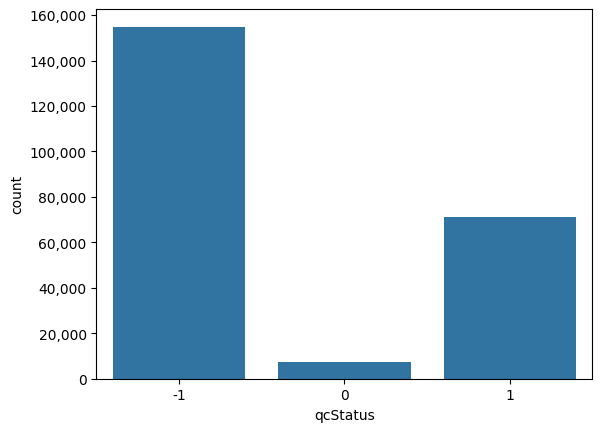

In [ ]:
serie = wunderground_registros['qcStatus'].value_counts()
sns.barplot(serie)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [ ]:
wunderground_registros_no_encontradas[wunderground_registros_no_encontradas['status_code']==200].max()


stationID                ISANTA538
date           2024-07-10 00:00:00
status_code                    200
dtype: object

In [ ]:
wunderground_registros_no_encontradas['date'] = pd.to_datetime(wunderground_registros_no_encontradas['date'])

In [ ]:
wunderground_registros_no_encontradas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 0 to 5278
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   stationID    5279 non-null   object        
 1   date         5279 non-null   datetime64[ns]
 2   status_code  5279 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 165.0+ KB


In [ ]:
wunderground_registros_no_encontradas['status_code'].unique()

array([200, 401])

## fecha de primer reporte de cada estación

In [23]:
df_cuentas_wunder=pd.read_excel('./info_wunder.xlsx','apiKeys',skiprows=2)

In [24]:
api_keys=df_cuentas_wunder['apiKey']
api_keys

0     0f80b73561fe451b80b73561fe651b08
1     9018fead0aa34de798fead0aa32de757
2     81f6557ebe8547f9b6557ebe8567f95e
3     ff3d7deb35a444ebbd7deb35a444ebbd
4     2bd1dee00a454ebe91dee00a458ebe79
5     e2aa52fada2f4902aa52fada2fa902e1
6     3ad659ace1134a8f9659ace113aa8f81
7     14527949de8b4a11927949de8bfa113d
8     3f3b3235558d473dbb3235558df73d22
9     40f85fd26c3d4861b85fd26c3dc86146
10    33914afbb3aa4bad914afbb3aaebad27
11    08815bdc1efa41a1815bdc1efa51a139
12    a73d7df1ccf04596bd7df1ccf0f59636
13    8b80656dee6f4fc580656dee6fcfc542
14    ec77cca0d1b7488bb7cca0d1b7e88bed
15    ae6e762c6d084cd4ae762c6d083cd4ae
16    f4330c3d495243f8b30c3d495263f8a0
17    52f0f4d954c144aab0f4d954c194aa00
18    cd599783fc4e4d7d999783fc4ecd7d6c
19    e220a3bad8254f49a0a3bad825bf49e3
20    10f9f411db3040bab9f411db3000ba32
21    4902c626326f4fb782c626326fffb738
22    e20206c8df604ef28206c8df606ef232
23    6e0b4795fa9e4ed68b4795fa9e2ed6bc
24    610a5b77df2040408a5b77df20f040ca
25    cf7afe50bfd84f16baf

In [13]:
estaciones_elegidas

id
0       IADELI1
1       IAMENB2
2       IARIAS1
3      IARMST25
4      IBELGR31
..          ...
138   IVILLA133
139  IVILLA1083
140      IPREZ1
141    ICASER41
142    ICASER32

[143 rows x 1 columns]

In [14]:
fecha=date(2020,1,1)
fecha_limite = date(2024,8,18)
obs=[]
numero_llamada=0
numero_api_key=22
api_key=api_keys[numero_api_key-1]
error_while=False
error_conexion=0
with open('./estaciones_fecha_primer_registro.csv','a',newline='') as csv_file:
    writer = csv.writer(csv_file)
    for estacion in estaciones_elegidas['id'][15:]:
        while fecha<fecha_limite and obs==[]:      
            if (numero_llamada==1400):
                print('campio de api key por llamada 1400')
                print('vieja api key',api_key)
                if (numero_api_key==30):
                    print('Se termina la ejecución porque se agotaron todas las apiKey')
                    print(recurso)
                    error_while=True
                    break  
                numero_api_key+=1 
                numero_llamada=0
                api_key=api_keys[numero_api_key-1]
                print('nueva api key',api_key)
                       
            fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
            recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
            try:
                respuesta = requests.get(recurso)
                numero_llamada+=1
                if (respuesta.status_code==200):
                    obs = respuesta.json()['observations']
                    fecha+= timedelta(days=1)
                 
                else:
                    print('campio de api key por respuesta 401')
                    print('vieja api key',api_key)
                    if (numero_api_key==30):
                        print('error 401: Se termina la ejecución porque se agotaron todas las apiKey')
                        print(recurso)
                        print(f'numero de llamada:{numero_llamada}')
                        error_while=True
                        break
                    numero_api_key+=1 
                    numero_llamada=0
                    api_key=api_keys[numero_api_key-1]
                    print('nueva api key',api_key)
                    
            except requests.exceptions.RequestException as error:
                error_conexion+=1
                print(f'error de conexión {error_conexion}')
                print(error)              
        if error_while:
            break
        if fecha==fecha_limite:
            print(f'debe escribirse {estacion} sin registro')
            registro=[estacion,'no se encontraron registros']
            writer.writerow(registro)
        if (obs!=[]):
            print(f'debe escribirse {estacion} con fecha {fecha}')
            registro=[estacion,fecha]
            writer.writerow(registro)
        fecha=date(2020,1,1)
        obs=[]
print('el bucle se ejecutó completamente')    
                

debe escribirse ICASER40 con fecha 2022-06-27
campio de api key por llamada 1400
vieja api key 4902c626326f4fb782c626326fffb738
nueva api key e20206c8df604ef28206c8df606ef232
debe escribirse ICASER42 con fecha 2022-10-19
campio de api key por llamada 1400
vieja api key e20206c8df604ef28206c8df606ef232
nueva api key 6e0b4795fa9e4ed68b4795fa9e2ed6bc
debe escribirse ICASIL2 con fecha 2022-12-29
debe escribirse ICOLN10 con fecha 2020-01-02
debe escribirse ICONST54 con fecha 2022-04-30
debe escribirse ICONSTIT2 con fecha 2020-01-02
debe escribirse ICONSTIT3 con fecha 2020-01-02
debe escribirse ICONSTIT4 con fecha 2020-01-02
debe escribirse ICORDOBA23 con fecha 2020-01-02
debe escribirse ICRDOBAV12 con fecha 2020-01-02
campio de api key por llamada 1400
vieja api key 6e0b4795fa9e4ed68b4795fa9e2ed6bc
nueva api key 610a5b77df2040408a5b77df20f040ca
debe escribirse IDEPAR62 con fecha 2021-03-28
debe escribirse IDEPAR77 con fecha 2021-08-11
campio de api key por llamada 1400
vieja api key 610a5b7

KeyError: 30

In [2]:
llamada=1
while True:
    try:
        respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=m&apiKey=0782f5ea000b4f6382f5ea000bdf63b1&numericPrecision=decimal&date=20240101')
        if (respuesta.status_code==401):
            print('error 401')
            break
        print(llamada)
        llamada+=1
    except requests.exceptions.RequestException as error:
        print('error')  
print('fin del bucle while')          


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

KeyboardInterrupt: 

## endpoint: observación corriente

In [ ]:
wunderground_estaciones = pd.DataFrame(columns=['stationID','lat','lon','neighborhood','softwareType'])
wunderground_estaciones_no_encontradas = pd.DataFrame(columns=['stationID','status_code'])
for estacion_id in estaciones_elegidas['id']:
    respuesta = requests.get(f'https://api.weather.com/v2/pws/observations/current?stationId={estacion_id}&format=json&units=m&apiKey=e6acbfe3f2504fe7acbfe3f250afe70a&numericPrecision=decimal')
    if (respuesta.status_code==200):
        estacion = respuesta.json()['observations'][0]
        estacion_filtrada=estacion_filtrada=[estacion['stationID'],estacion['lat'],estacion['lon'],estacion['neighborhood'],estacion['softwareType']]
        wunderground_estaciones.loc[len(wunderground_estaciones)] = estacion_filtrada
    else:
        #Estaciones offline
        #Error 204: No Data Found for specific query. The 204 status code will have an empty response body.
        estacion_error = [estacion_id,respuesta.status_code]
        wunderground_estaciones_no_encontradas.loc[len(wunderground_estaciones_no_encontradas)] = estacion_error


In [ ]:
wunderground_estaciones.head()

stationID        lat        lon         neighborhood           softwareType
0   IADELI1 -33.635801 -64.021607         Adelia María  EasyWeatherPro_V5.0.2
1   IAMENB2 -34.158235 -62.419065             Amenábar              myAcuRite
2  IBELGR31 -32.562904 -61.767025  Belgrano Department      EasyWeatherV1.6.5
3   IBUSTI3 -32.714858 -61.227587             Bustinza  EasyWeatherPro_V5.1.1
4   ICAADA2 -32.819239 -61.400655      Cañada de Gómez      EasyWeatherV1.5.2

In [ ]:
wunderground_estaciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 0 to 115
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stationID     116 non-null    object 
 1   lat           116 non-null    float64
 2   lon           116 non-null    float64
 3   neighborhood  115 non-null    object 
 4   softwareType  110 non-null    object 
dtypes: float64(2), object(3)
memory usage: 5.4+ KB


In [ ]:
wunderground_estaciones_no_encontradas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   stationID    27 non-null     object
 1   status_code  27 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 648.0+ bytes


In [ ]:
wunderground_estaciones_no_encontradas['status_code'].unique()

array([204])

## Bloques auxiliares

In [6]:
def cuentas_api_keys_401(cuentas_wunder:pd.DataFrame)->list[str]:
    """abre el csv que asocia cada cuenta con su respectiva apiKey
    y devuelve una lista con aquellas cuentas cuya apiKey que no se 
    pueden utlizar"""
    cuentas_desautorizadas=[]
    for index,registro in cuentas_wunder.iterrows():
        cuenta,apiKey=registro
        recurso=f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=e&apiKey={apiKey}&numericPrecision=decimal&date=20230701'
        respuesta = requests.get(recurso)
        if (respuesta.status_code==401):
            cuentas_desautorizadas.append(cuenta)  
    return cuentas_desautorizadas

In [7]:
cuentas_api_keys_401(df_cuentas_wunder)

[]

In [ ]:

for i in range(500):
    respuesta = requests.get(f'https://api.weather.com/v2/pws/observations/current?stationId=IADELI1&format=json&units=m&apiKey=e6acbfe3f2504fe7acbfe3f250afe70a&numericPrecision=decimal')
    if respuesta.status_code!=200:
        llamada_limite= (i,respuesta)
        break
    if (i==499):
        ultima_llamada = respuesta
print(ultima_llamada.json())

In [ ]:
numero_llamada = 1
while True:
    try:
        respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=m&apiKey=a2aa831a495746adaa831a495786adcd&numericPrecision=decimal&date=20230101')
        if (respuesta.status_code==401):
            print(numero_llamada)
            print(datetime.now())
            break
        else:
            numero_llamada+=1
    except requests.exceptions.RequestException as error:
        print('error:',error)
        print(datetime.now())
        break



1
2024-08-15 12:46:09.078602


In [ ]:
try:
    respuesta = requests.get(f'https://api.weather.com/v2/pws/history/all?stationId=IADELI1&format=json&units=m&apiKey=a2aa831a495746adaa831a495786adcd&numericPrecision=decimal&date=20230101')
    if (respuesta.status_code==401):
        print(numero_llamada)
    else:
        numero_llamada+=1
except requests.exceptions.RequestException as error:
    print('error:',error)

error: HTTPSConnectionPool(host='api.weather.com', port=443): Max retries exceeded with url: /v2/pws/history/all?stationId=IADELI1&format=json&units=m&apiKey=a2aa831a495746adaa831a495786adcd&numericPrecision=decimal&date=20230101 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002241992DF90>: Failed to resolve 'api.weather.com' ([Errno 11001] getaddrinfo failed)"))


## BeatifulSoup

In [ ]:
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""
soup = BeautifulSoup(html_doc,'lxml')
tables=soup.findAll('table')
for table in tables:
    print(table)

In [17]:
from bs4 import BeautifulSoup
html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""
import requests
URL = "https://www.wunderground.com/dashboard/pws/ISANLORE34/table/2024-08-2/2024-08-2/monthly"
r = requests.get(URL)
soup = BeautifulSoup(r.text,'lxml')
soup

<!DOCTYPE html>
<html itemscope="" itemtype="http://schema.org/Organization" lang="en" prefix="og: http://ogp.me/ns#"><head itemscope="" itemtype="http://schema.org/WebSite">
<meta charset="utf-8"/>
<title>Personal Weather Station Dashboard | Weather Underground</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="//widgets.outbrain.com" rel="dns-prefetch"/>
<link href="//odb.outbrain.com" rel="dns-prefetch"/>
<link href="//c.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//s.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//aax.amazon-adsystem.com" rel="dns-prefetch"/>
<link href="//partner.googleadservices.com" rel="dns-prefetch"/>
<link href="//tpc.googlesyndication.com" rel="dns-prefetch"/>
<link href="//pagead2.googlesyndication.com" rel="dns-prefetch"/>
<link href="//h.nexac.com" rel="dns-prefetch"/>
<link href="//js-sec.indexww.com" rel="dns-prefetch"/>
<link href="/